In [88]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [89]:
# generates training data
def gen_data(num_data, seed = 2024):
    torch.random.manual_seed(seed)

    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)

    # u = torch.rand(1)
    data_fn_obj = lambda x,y: torch.cos(2*x)*torch.cos(y) + torch.sin(x) # toy function
    latent_fn_obj = data_fn_obj(x, y)
    z_obj = latent_fn_obj.squeeze()
    data_fn_cnt = lambda x, y: torch.cos(x)*torch.cos(y) - torch.sin(x)*torch.sin(y)
    latent_fn_cnt = data_fn_cnt(x, y)
    z_cnt = torch.heaviside(latent_fn_cnt - 0.5, torch.zeros(latent_fn_cnt.shape)).long().squeeze()
    return torch.cat((x,y),dim=1), z_obj, z_cnt, data_fn_obj, data_fn_cnt

In [90]:
# generate training data - y= objective values, c=class label
train_x, train_y, train_c, genfn_obj, genfn_cnt = gen_data(500)

# test data generate - uniform across [-3, 3] x [-3, 3]
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_x1_mat, test_x2_mat = np.meshgrid(test_d1, test_d2)
test_x1_mat, test_x2_mat = torch.Tensor(test_x1_mat), torch.Tensor(test_x2_mat)

test_x = torch.cat((test_x1_mat.view(-1,1), test_x2_mat.view(-1,1)), dim=1)
test_y = genfn_obj(test_x1_mat, test_x2_mat)
test_y = test_y.view(-1)
test_latent_cnt = genfn_cnt(test_x1_mat, test_x2_mat)
test_labels = torch.heaviside(test_latent_cnt - 0.5, torch.zeros(test_latent_cnt.shape))
test_c = test_labels.view(-1)

In [91]:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [92]:
# GP class for regression
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# GP class for classification
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [93]:
# function to optimize parameters of the classification GP - 
def train_cls_gp(model, likelihood, training_iter):
   # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        # if i % 5 == 0:
        #     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #         i + 1, training_iter, loss.item(),
        #         model.covar_module.base_kernel.lengthscale.mean().item(),
        #         model.likelihood.second_noise_covar.noise.mean().item()
        #     ))
        optimizer.step()

    return model, likelihood


In [94]:
# function to optimize parameters of the regression GP -
def train_reg_gp(model, likelihood, training_iter):
   # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        # if i % 5 == 0:
        #     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #         i + 1, training_iter, loss.item(),
        #         model.covar_module.base_kernel.lengthscale.item(),
        #         model.likelihood.noise.item()
        #     ))
        optimizer.step()

    return model, likelihood 

In [95]:
# calculate acquisition function
# Expected improvement, maximizing y
def calculate_acf(pred_mean, pred_std, y_max):
    # improve = pred_mean - y_max # maximizing
    improve = y_max - pred_mean # minimizing
    z_score = np.divide(improve, pred_std + 1e-9)
    acf = np.multiply(improve, norm.cdf(z_score)) + np.multiply(pred_std, norm.pdf(z_score))
    return acf

# to do replacement, before calculate_acf
def feasible_replace(class_mat,pred_means_mat):
    feasible = torch.max(0*class_mat,-1*class_mat)
    feasible_vals = feasible*pred_means_mat

    worst = torch.max(pred_means_mat)
    feasible_vals[feasible_vals==0] = worst
    return feasible_vals

In [96]:
#initialize likelihood and model - regression
reg_likelihood = gpytorch.likelihoods.GaussianLikelihood()
reg_model = ExactGPModel(train_x, train_y, reg_likelihood)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
cls_likelihood = DirichletClassificationLikelihood(train_c, learn_additional_noise=True)
cls_model = DirichletGPModel(train_x, cls_likelihood.transformed_targets, cls_likelihood, num_classes=cls_likelihood.num_classes)

# train models
reg_model, reg_likelihood = train_reg_gp(reg_model, reg_likelihood, 50)
cls_model, cls_likelihood = train_cls_gp(cls_model, cls_likelihood, 50)

# prediction - objective values
reg_model.eval()
reg_likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    obj_pred = reg_likelihood(reg_model(test_x))
    obj_pred_means = obj_pred.loc
    obj_means_mat = obj_pred_means.reshape((20, 20))

    lower, upper = obj_pred.confidence_region()
    lower_mat, upper_mat = lower.reshape((20, 20)), upper.reshape((20, 20))
    confidence = torch.abs(lower-upper)
    confidence_mat = torch.abs(lower_mat-upper_mat)

# prediction - class probabilities
cls_model.eval()
cls_likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    logit_dist = cls_model(test_x)
    logit_means = logit_dist.loc
    logit_stddevs = logit_dist.stddev

# calculate probabilites from the logit values
samples = logit_dist.sample(torch.Size((256,))).exp()
class_probabilites = (samples / samples.sum(-2, keepdim=True)).mean(0)

# find the min objective value in training points
best_idx = np.argmin(train_y)
x_best = train_x[best_idx, :]
y_best = train_y[best_idx]

# calculate expected improvement
#obj_pred_means = feasible_replace(logit_means.max(0)[1].reshape(20,20)-1,obj_pred_means.reshape(20,20))
ei = calculate_acf(obj_pred_means.reshape(400), obj_pred.stddev, y_best)
#ei = calculate_acf(obj_pred_means, confidence, y_best) # which is better - stddev or confidence?

# multiply by the classification probability
fwa_old = ei * class_probabilites[0]
#fwa_old = ei
fwa_mat = fwa_old.reshape(20,20) # for plotting
fwa_best_idx = torch.argmax(fwa_old) # index of best
x_best = test_x[fwa_best_idx,:]

# update training data
train_x = torch.cat((train_x,x_best.view(1,2)),0)
train_y = torch.cat((train_y,genfn_obj(x_best[0],x_best[1]).view(1)),0)
latent_fn_cnt = genfn_cnt(x_best[0],x_best[1]).view(1)
train_c = torch.cat((train_c,torch.heaviside(latent_fn_cnt - 0.5, torch.zeros(latent_fn_cnt.shape)).long()),0)

c:\Users\bcste\anaconda3\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\bcste\anaconda3\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


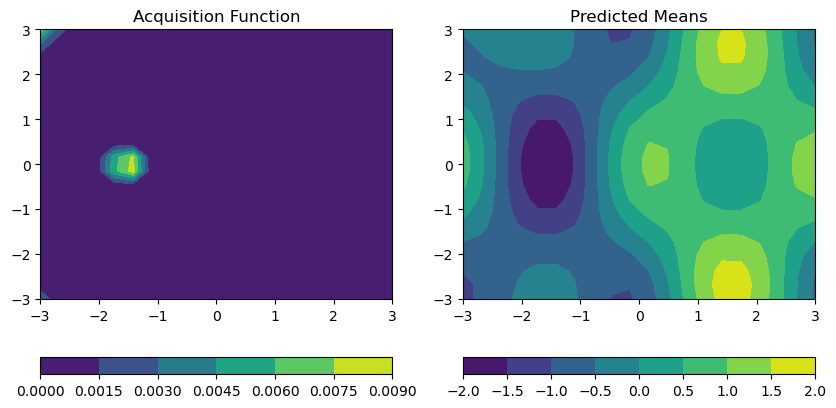

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

f1 = ax[0].contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), fwa_mat.numpy())
ax[0].set_title('Acquisition Function')

f2 = ax[1].contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), obj_means_mat.numpy())
ax[1].set_title('Predicted Means')

fig.colorbar(f1,location = 'bottom')
fig.colorbar(f2,location = 'bottom')
plt.show()

In [98]:
bo_batch_size = 1
error = 1
tol = 1e-5
iter = 0
#for iter in range(2):
while iter < 1000 and error > tol:
    
    #initialize likelihood and model - regression
    reg_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    reg_model = ExactGPModel(train_x, train_y, reg_likelihood)

    # initialize likelihood and model
    # we let the DirichletClassificationLikelihood compute the targets for us
    cls_likelihood = DirichletClassificationLikelihood(train_c, learn_additional_noise=True)
    cls_model = DirichletGPModel(train_x, cls_likelihood.transformed_targets, cls_likelihood, num_classes=cls_likelihood.num_classes)

    # train models
    reg_model, reg_likelihood = train_reg_gp(reg_model, reg_likelihood, 50)
    cls_model, cls_likelihood = train_cls_gp(cls_model, cls_likelihood, 50)
    # prediction - objective values
    reg_model.eval()
    reg_likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        obj_pred = reg_likelihood(reg_model(test_x))
        obj_pred_means = obj_pred.loc
        obj_means_mat = obj_pred_means.reshape((20, 20))

        lower, upper = obj_pred.confidence_region()
        lower_mat, upper_mat = lower.reshape((20, 20)), upper.reshape((20, 20))
        confidence = torch.abs(lower-upper)
        confidence_mat = torch.abs(lower_mat-upper_mat)

    # prediction - class probabilities
    cls_model.eval()
    cls_likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        logit_dist = cls_model(test_x)
        logit_means = logit_dist.loc
        logit_stddevs = logit_dist.stddev

    # calculate probabilites from the logit values
    samples = logit_dist.sample(torch.Size((256,))).exp()
    class_probabilites = (samples / samples.sum(-2, keepdim=True)).mean(0)

    # find the min objective value in training points
    best_idx = np.argmin(train_y)
    x_best = train_x[best_idx, :]
    y_best = train_y[best_idx]

    # calculate expected improvement
    #obj_pred_means = feasible_replace(logit_means.max(0)[1].reshape(20,20)-1,obj_pred_means.reshape(20,20))
    ei = calculate_acf(obj_pred_means.reshape(400), obj_pred.stddev, y_best)
    #ei = calculate_acf(obj_pred_means, confidence, y_best) # which is better - stddev or confidence?

    # multiply by the classification probability
    fwa = ei * class_probabilites[0] # feasibility weighted acquisition
    #fwa = ei
    fwa_mat = fwa.reshape(20,20) # for plotting

    # top 5 candidate points from constrained ei
    top5_ind = np.argpartition(fwa, -bo_batch_size)[-bo_batch_size:]
    top5_ind = top5_ind[np.argsort(fwa[top5_ind])]

    #locations & values of top candidate points
    candidate_x = test_x[top5_ind, :]
    top5_obj_vals = genfn_obj(candidate_x[:,0], candidate_x[:, 1])

    # update training data
    train_x = torch.cat((train_x,candidate_x),0)
    train_y = torch.cat((train_y,top5_obj_vals),0)
    latent_fn_cnt = genfn_cnt(x_best[0],x_best[1]).view(1)
    train_c = torch.cat((train_c,class_probabilites.max(0)[1][top5_ind]),0)

    # check convergence
    error = torch.linalg.vector_norm(fwa-fwa_old,np.inf).numpy()
    iter += 1

    fwa_old = fwa


c:\Users\bcste\anaconda3\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


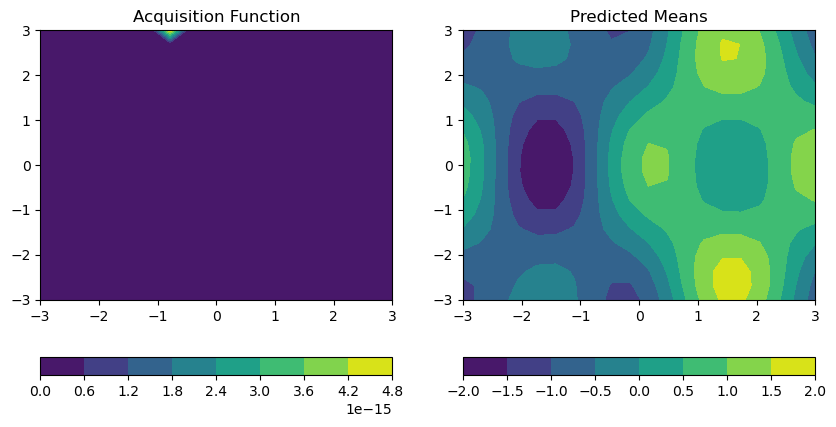

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

f1 = ax[0].contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), fwa_mat.numpy())
ax[0].set_title('Acquisition Function')

f2 = ax[1].contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), obj_means_mat.numpy())
ax[1].set_title('Predicted Means')

fig.colorbar(f1,location = 'bottom')
fig.colorbar(f2,location = 'bottom')
plt.show()

In [111]:
torch.min(obj_pred_means)
train_y[best_idx]
iter*bo_batch_size
train_x[best_idx]

tensor([-1.5981,  0.0509])

In [101]:
# #initialize likelihood and model - regression
# reg_likelihood = gpytorch.likelihoods.GaussianLikelihood()
# reg_model = ExactGPModel(train_x, train_y, reg_likelihood)

# # initialize likelihood and model
# # we let the DirichletClassificationLikelihood compute the targets for us
# cls_likelihood = DirichletClassificationLikelihood(train_c, learn_additional_noise=True)
# cls_model = DirichletGPModel(train_x, cls_likelihood.transformed_targets, cls_likelihood, num_classes=cls_likelihood.num_classes)

In [102]:
# print("Training Regression model")
# reg_model, reg_likelihood = train_reg_gp(reg_model, reg_likelihood, 50)
# print("Training Classification model")
# cls_model, cls_likelihood = train_cls_gp(cls_model, cls_likelihood, 50)

In [103]:
# # prediction - objective values
# reg_model.eval()
# reg_likelihood.eval()

# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     obj_pred = reg_likelihood(reg_model(test_x))
#     obj_pred_means = obj_pred.loc
#     obj_means_mat = obj_pred_means.reshape((20, 20))

#     lower, upper = obj_pred.confidence_region()
#     lower_mat, upper_mat = lower.reshape((20, 20)), upper.reshape((20, 20))
#     confidence = torch.abs(lower-upper)
#     confidence_mat = torch.abs(lower_mat-upper_mat)

In [104]:
# # prediction - class probabilities
# cls_model.eval()
# cls_likelihood.eval()

# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     logit_dist = cls_model(test_x)
#     logit_means = logit_dist.loc
#     logit_stddevs = logit_dist.stddev

# # calculate probabilites from the logit values
# samples = logit_dist.sample(torch.Size((256,))).exp()
# class_probabilites = (samples / samples.sum(-2, keepdim=True)).mean(0)

In [105]:
# fig, ax = plt.subplots(1, 2, figsize=(10,5))

# ax[0].contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), genfn_obj(test_x1_mat, test_x2_mat))
# ax[0].set_title('Test function')

# ax[1].contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), obj_means_mat)
# ax[1].set_title('Predicted Means')

# plt.show()

In [106]:
# # feasible class probabilities
# levels = np.linspace(0, 1.05, 20)
# plt.contourf(test_x1_mat.numpy(), test_x2_mat.numpy(), class_probabilites[0].numpy().reshape((20,20)), levels=levels)
# plt.colorbar()
# plt.title("Probabilites: Feasible region")
# plt.show()

In [107]:

# # find the min objective value in training points
# best_idx = np.argmin(train_y)
# x_best = train_x[best_idx, :]
# y_best = train_y[best_idx]

# worst_idx = np.argmax(train_y)
# y_worst = train_y[worst_idx]

# ei = calculate_acf(obj_pred_means, obj_pred.stddev, y_best)
# #ei = calculate_acf(obj_pred_means, confidence, y_best) # which is better - stddev or confidence?

In [108]:
# # multiply by the classification probability
# fwa = ei * class_probabilites[0]
# fwa_mat = fwa.reshape(20,20) # feasibility weighted acquisition
# plt.contourf(test_x1_mat.numpy(),test_x2_mat.numpy(),fwa_mat.numpy())
# plt.colorbar()